# Kinetic proofreading in templated replication; in-silico evolution

We implement our in-silico evolution work using random networks with a family of proofreading models as detailed in the Material and Methods.

#### Import modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy.linalg import inv
from numpy.linalg import pinv
from numpy.linalg import eig
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import palettable as pal
import itertools
import random

import copy
from tqdm.notebook import trange, tqdm
from matplotlib.ticker import LogLocator
from matplotlib.ticker import ScalarFormatter
from scipy import linalg as LA

import seaborn as sns
%matplotlib inline
sns.set_context("talk",rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":20})
sns.set_style("whitegrid",{"grid.color": '.9', 'grid.linestyle': '--','axes.edgecolor': '.6', \
                           'xtick.bottom': True,'ytick.left': True})

Import functions from these scripts needed to define the random network, its evolution and plot the relevant observables.

In [3]:
from physics import *
from network import *
from tools import save_vars
from evolution import *

## Random copier network

Parameters chosen for different sizes

|Number of nodes ($N$) | $T$ | $t_{\rm{stall}}$| $\delta$| size | dsize|
|-----------|-----|-----------------|---------|------|------|
|7| $10^{-2}$| $10^3$| 0.4| 7| 0.2|
|3| $10^{-3}$| $10^3$| 0.4| 5| 0.5|


The following code is defined for $N=7$; parameters can be changed for $N=3$ simulations.

### Initialise parameters

In [53]:
N = 7 #  Size of the network
delta = 0.4   # Defining the perturbation (quenched): the kinetics difference between R and W \
              #is fixed to be at most e^delta (-delta < eps < delta)
init = 0      # Definition of the initial state
size = 7
dsize = 0.2
maxsize = 5

eps_v, eps_b, p_0, end, V, B, mu, k_r, k_w, V_0, B_0, mu_0 = initialise_network(N, delta, init, size, dsize, maxsize)

Genome: [-7.00000000e+00 -6.80000000e+00 -6.60000000e+00 -6.40000000e+00
 -6.20000000e+00 -6.00000000e+00 -5.80000000e+00 -5.60000000e+00
 -5.40000000e+00 -5.20000000e+00 -5.00000000e+00 -4.80000000e+00
 -4.60000000e+00 -4.40000000e+00 -4.20000000e+00 -4.00000000e+00
 -3.80000000e+00 -3.60000000e+00 -3.40000000e+00 -3.20000000e+00
 -3.00000000e+00 -2.80000000e+00 -2.60000000e+00 -2.40000000e+00
 -2.20000000e+00 -2.00000000e+00 -1.80000000e+00 -1.60000000e+00
 -1.40000000e+00 -1.20000000e+00 -1.00000000e+00 -8.00000000e-01
 -6.00000000e-01 -4.00000000e-01 -2.00000000e-01  6.21724894e-15
  2.00000000e-01  4.00000000e-01  6.00000000e-01  8.00000000e-01
  1.00000000e+00  1.20000000e+00  1.40000000e+00  1.60000000e+00
  1.80000000e+00  2.00000000e+00  2.20000000e+00  2.40000000e+00
  2.60000000e+00  2.80000000e+00  3.00000000e+00  3.20000000e+00
  3.40000000e+00  3.60000000e+00  3.80000000e+00  4.00000000e+00
  4.20000000e+00  4.40000000e+00  4.60000000e+00  4.80000000e+00] Length: 60
Error

#### Example for a maximal proofreading network for a given N

This is just testing that the functions defined make sense, partiularly the error one. The rates are defined ad hoc for a network that is poised at maximal discrimination.

In [54]:
kr_pr = np.zeros([N,N])
for i in range(N-1):
    kr_pr[i+1,i] = 0.8
    kr_pr[i,i+1] = 1e-2
    
kw_pr = copy.copy(kr_pr)
#kw_pr[1,2] = np.exp(delta)*kw_pr[1,2]
for i in range(N-1):
    kw_pr[i,i+1] = np.exp(delta)*kw_pr[i,i+1]
    
kr_pr = normalise_outflow(kr_pr, N)
kw_pr = normalise_outflow(kw_pr, N)

# Definition of the initial state
init = 0
p_0 = np.zeros((N,1))
p_0[init] = 1

# Definition of the final state
end = N-1
print('First passage time:', firstpt(kr_pr, p_0, N, end)[0], 'First passage time kinetic stalled:', firstpt(1e3*kr_pr, p_0, N, end)[0])

print('Maximal proofreading:', error(kr_pr, kw_pr, N, init, end),  'e^{-\Delta}:', np.exp(-(N-1)*delta))

First passage time: 7.578913635635373 First passage time kinetic stalled: 0.007578913635635366
Maximal proofreading: 0.09071766053673494 e^{-\Delta}: 0.09071795328941247


### Evolving the network

In [55]:
q = 0 # Cost to dissipation is set to zero
n_samples = 10
mcsteps = 10000
T = 1e-2 # Evolution temperature

    
t_st = [1e3] # Stalling time

track_e, track_S = [ [] for i in range(2)]

for t_stall in t_st:
    print('Stalling time: ', t_stall)
    
    track_error_s, track_speed_s, track_fpt_s, track_fptw_s, track_mu_s, \
    track_ent_s, track_time_s, track_k_s = evolve(N, mcsteps, T, t_stall, q, delta, n_samples, \
                                                  size, dsize, maxsize)

Stalling time:  1000.0


Quickly plotting the result of the evolution to check the outcome

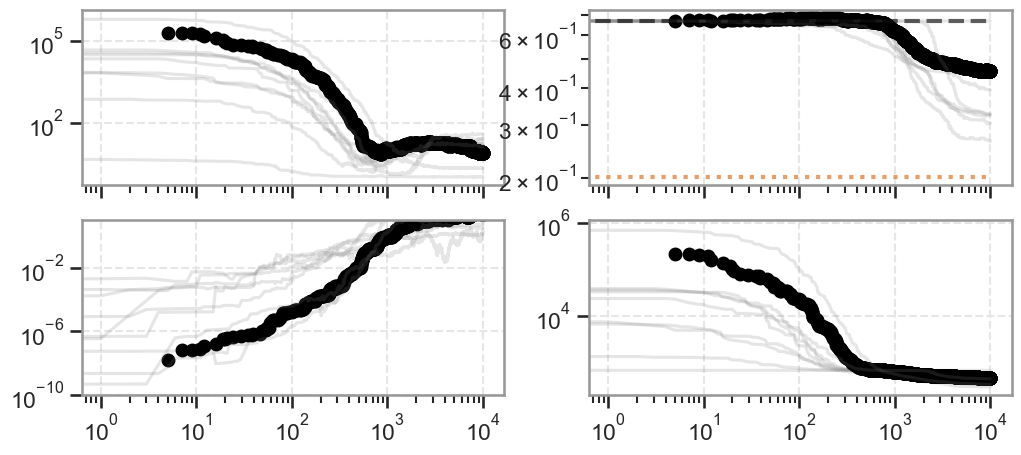

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 5), sharex=True)
for idx in range(n_samples):
    if idx == 7:
        axs[0,0].plot(np.asarray(track_time_s[idx]), np.abs(np.asarray(track_fpt_s[idx])), 'ko')
        axs[0,1].plot(np.asarray(track_time_s[idx]), np.abs(np.asarray(track_error_s[idx])), 'ko')
        
        axs[1,0].plot(np.asarray(track_time_s[idx]), np.abs(np.asarray(track_ent_s[idx])), 'ko')
        axs[1,1].plot(np.asarray(track_time_s[idx]), np.abs(np.asarray(track_speed_s[idx])), 'ko')
    else:
        axs[0,0].plot(np.asarray(track_time_s[idx]), np.abs(np.asarray(track_fpt_s[idx])), '-', color='grey', markersize=3, alpha=0.2)
        axs[0,1].plot(np.asarray(track_time_s[idx]), np.abs(np.asarray(track_error_s[idx])), '-', color='grey', markersize=3, alpha=0.2)
        
        axs[1,0].plot(np.asarray(track_time_s[idx]), np.abs(np.asarray(track_ent_s[idx])), '-', color='grey', markersize=3, alpha=0.2)
        axs[1,1].plot(np.asarray(track_time_s[idx]), np.abs(np.asarray(track_speed_s[idx])), '-', color='grey', markersize=3, alpha=0.2)

xlim = axs[0,1].get_xlim()
axs[0,1].plot(xlim, [np.exp(-delta), np.exp(-delta)], '--', color = 'black', linewidth=3, alpha=0.6, label=r'$e^{-\Delta}$')
axs[0,1].plot(xlim, [np.exp(-(N-int(N/2))*delta), np.exp(-(N-int(N/2))*delta)], ':', color=(0.85, 0.37, 0.01), linewidth=3, \
              alpha=0.6, label=r'$e^{-2\Delta}$')
axs[0,0].set_yscale('log')
axs[0,1].set_yscale('log')
axs[1,0].set_yscale('log')
axs[1,0].set_ylim([1e-10,1e1])
axs[1,1].set_yscale('log')
axs[0,0].set_xscale('log')

Load the trajectories used to make the plot in Fig. 1 have been evolved with the code above and saved in a .pkl file for future use.

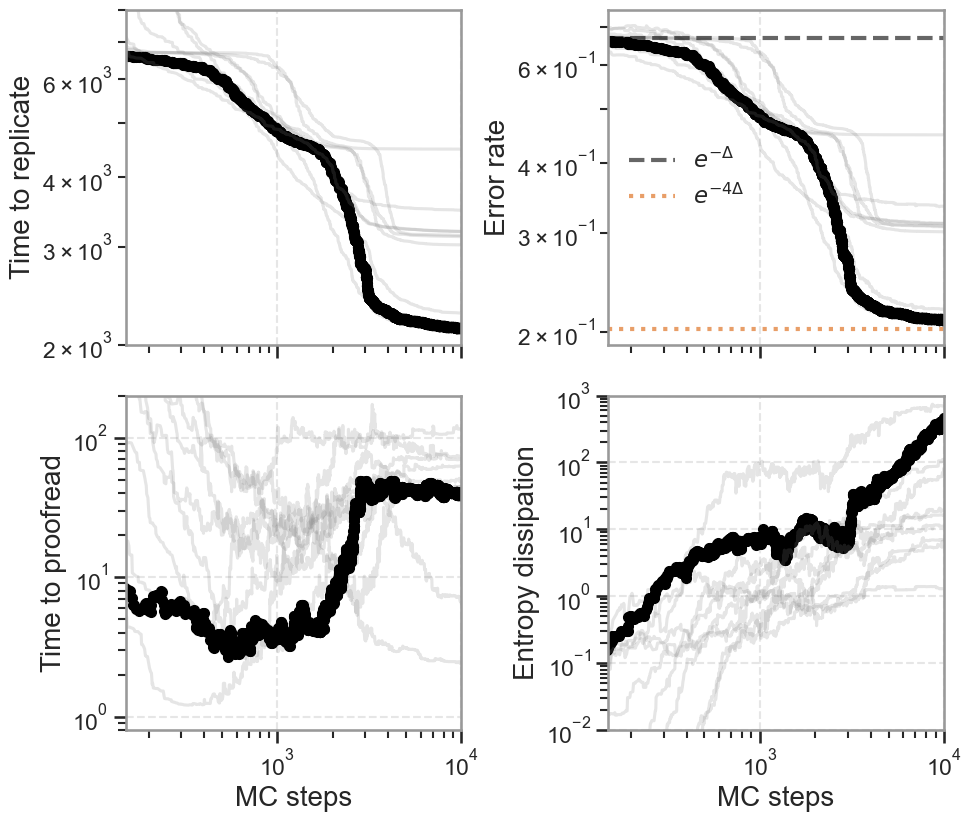

In [18]:
import pickle
with open('kinetic-proofreading_data/N_7_10_trajs.pickle', 'rb') as handle:
    trajs = pickle.load(handle)

N = 7 #  Size of the network
delta = 0.4   # Defining the perturbation (quenched): the kinetics difference between R and W \

track_time_s =  trajs[0]
track_error_s = trajs[2]
track_fpt_s = trajs[4]
track_ent_s = trajs[3]
track_speed_s = trajs[1]
t_stall = 1e3
T = 1e-2
n_samples = 10

%autoreload
from plot import plot_observables
idx_s = 8
plot_observables(idx_s, delta, track_time_s, track_speed_s, track_error_s, track_ent_s, track_fpt_s, N, \
                 t_stall, T, n_samples)

Code below is to save trajectories, if need so

In [ ]:
# if (N == 3):
#     import pickle
#     trajs = [track_time_s, track_speed_s, track_error_s, track_ent_s, track_fpt_s, track_k_s]
#     with open('N_3_trajs.pickle', 'wb') as handle:
#         pickle.dump(trajs, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
# if (N == 7):
#     import pickle
#     trajs = [track_time_s, track_speed_s, track_error_s, track_ent_s, track_fpt_s, track_k_s]
#     with open('N_7_trajs.pickle', 'wb') as handle:
#         pickle.dump(trajs, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Mutagenesis from an evolved network, WT equivalent

Evolve a network for speed, take the evolved solution as initial condition for mutagenesis. Mutant networks are defined by perturbing the kinetic parameters of the evolved networks: pick at random a kinetic rate and extract a new value from a Gaussian distribution centered around the original value. Different strength of mutagenesis are considered, corresponding to different values of the variance of the distribution.

|Number of nodes ($N$) | $T$ | $t_{\rm{stall}}$| $\delta$| size | dsize|
|-----------|-----|-----------------|---------|------|------|
|7| $10^{-3}$| $10^3$| 2.5| 5| 0.5|


In [17]:
N = 7 #  Size of the network
delta = 2.5   # Defining the perturbation (quenched): the kinetics difference between R and W \
              #is fixed to be at most e^delta (-delta < eps < delta)
init = 0      # Definition of the initial state
size = 5
dsize = 0.5
maxsize = 5

eps_v, eps_b, p_0, end, V, B, mu, k_r, k_w, V_0, B_0, mu_0 = initialise_network(N, delta, init, size, dsize, maxsize)

Genome: [-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5
  2.   2.5  3.   3.5  4.   4.5] Length: 20
Error at initialisation: 0.08208499862398946 e^{-\Delta}: 0.0820849986238988
Sum over rows: [ 7.94093388e-21  5.42101086e-20 -8.67361738e-19 -1.43223107e-16
 -3.69306365e-19 -8.13151629e-20  4.33680869e-19]


In [18]:
q = 0
n_samples = 1
mcsteps = 100000
T = 1e-3 # Evolution temperature

t_st = [1e3]

track_e, track_S = [ [] for i in range(2)]

for t_stall in t_st:
    print(t_stall)
    
    track_error_s, track_speed_s, track_fpt_s, track_fptw_s, track_mu_s, \
    track_ent_s, track_time_s, track_k_s = evolve(N, mcsteps, T, t_stall, q, delta, n_samples, \
                                                  size, dsize, maxsize)

1000.0


In [20]:
ic = [ track_k_s[0][-1] ]
print(track_fpt_s[0][-1], track_error_s[0][-1], np
      .exp(-(N-int(N/2))*delta),  np.exp(-(N-int(N/2))*delta)/track_error_s[0][-1]*100)

2.1930368628942487 0.00037398702452895373 4.5399929762484854e-05 12.139439816038331


Run the mutagenesis

In [21]:
combs = int(1e6)
npt = 1 # Take only one point from the normal distribution
vec_pct = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9] # Defining how much variance from the starting kinetic
                                                                           # parameters to explore
K_tmp_r = np.zeros([N,N])

err_loc_v, fpt_loc_v, speed_loc_v = [[] for i in range(3)]
for s in range(len(ic)):
    params_ic = ic[s]
    for pct in vec_pct:
        err_loc, fpt_loc, speed_loc = [[] for i in range(3)]
        for c in range(combs):

            K_r, _ = build_matrix_params(params_ic[0], params_ic[1], params_ic[2], N, eps_v, eps_b)
            for i in range(N):
                for j in range(N):
                    if i !=j:
                        K_tmp_r[i,j] = abs(np.random.normal(K_r[i,j], pct*K_r[i,j], npt))

            K_tmp_r = normalise_outflow(K_tmp_r, N)
            K_tmp_r1 = copy.copy(K_tmp_r)/max_k(copy.copy(K_tmp_r))

            K_tmp_w = copy.copy(K_tmp_r)    
            for i in range(N):
                for j in range(N):
                    if i < int(N/2) and j >= int(N/2):
                        K_tmp_w[i,j] = K_tmp_w[i,j]*np.exp(delta)


            K_tmp_w = normalise_outflow(K_tmp_w, N)
            K_tmp_w1 = copy.copy(K_tmp_w)/max_k(copy.copy(K_tmp_r))

            fpt = firstpt(copy.copy(K_tmp_r1), p_0, N, end)
            err = error(K_tmp_r1, K_tmp_w1, N, init, end)
            err_loc.append( err )
            fpt_loc.append( fpt )
            speed_loc.append( fpt + t_stall*err )
        err_loc_v.append(err_loc)
        fpt_loc_v.append(fpt_loc)
        speed_loc_v.append(speed_loc)

/tmp/ipykernel_24615/362208561.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K_tmp_r[i,j] = abs(np.random.normal(K_r[i,j], pct*K_r[i,j], npt))


Plot the result of the mutagenesis

(0.5, 1000)

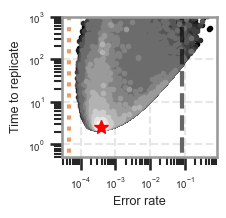

In [22]:
fig_width_inches = 2  # Width in inches - as requested
# Calculate height to maintain original proportions
original_ratio = 4.6/4.2
fig_height_inches = fig_width_inches / original_ratio  # = 3/1.625 = 1.85 inches

fig, axs = plt.subplots(1, 1, figsize=(fig_width_inches, fig_height_inches), sharex=True)
for i in reversed(range(len(vec_pct))):
        axs.plot(err_loc_v[i], speed_loc_v[i], 'o', \
                 color=pal.scientific.sequential.GrayC_12.mpl_colors[i], markersize=3, rasterized=True)

ylim = axs.get_ylim()
axs.plot([np.exp(-delta), np.exp(-delta)], ylim, '--', color = 'black', linewidth=3, alpha=0.6, label=r'$e^{-\Delta}$')
axs.plot([np.exp(-(N-int(N/2))*delta), np.exp(-(N-int(N/2))*delta)], ylim, ':', color=(0.85, 0.37, 0.01), linewidth=3, \
              alpha=0.6, label=r'$e^{-2\Delta}$')

K_r, _ = build_matrix_params(params_ic[0], params_ic[1], params_ic[2], N, eps_v, eps_b)
K_r = normalise_outflow(K_r, N)
K_w = copy.copy(K_r)    
for i in range(N):
    for j in range(N):
        if i < int(N/2) and j >= int(N/2):
            K_w[i,j] = K_w[i,j]*np.exp(delta)


K_w = normalise_outflow(K_w, N)
K_w = copy.copy(K_w)/max_k(copy.copy(K_r))

fpt = firstpt(copy.copy(K_r), p_0, N, end)
err = error(K_r, K_w, N, init, end)

axs.plot(err, fpt + t_stall*err, '*', \
                 color='red', markersize=10, rasterized=True)

# Set title and labels with customized font sizes
#ax.set_title(title, fontsize=10, pad=15, color='black', fontweight='normal')
axs.set_xlabel('', fontsize=9)  # X-axis label size
axs.set_ylabel('', fontsize=9, color='0.15')  # Y-axis label size 85% black

# Format axes - set tick label size and ensure ticks are visible
axs.tick_params(axis='both', labelsize=7, colors='0.15')
#axs.tick_params(axis='both', which='major', labelsize=7, colors='0.15', 
              #bottom=True, left=True, width=0.8, length=3.0)

axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlabel('Error rate')
axs.set_ylabel('Time to replicate')
axs.set_ylim([0.5,1*10**3])
#plt.savefig('theorytradeoff.pdf', dpi=300, bbox_inches='tight', facecolor='#fcfcfc')

## Looking for the trade-off

Random sampling for a network of size $N=3$. See later for loading the saved random sampling scatter plot. The following simulation takes time.

|Number of nodes ($N$) | $T$ | $t_{\rm{stall}}$| $\delta$| size | dsize|
|-----------|-----|-----------------|---------|------|------|
|3| $10^{-3}$| $10^2$| 0.4| 5| 0.5|

In [4]:
N = 3         #  Size of the network
delta = 0.4   # Defining the perturbation (quenched): the kinetics difference between R and W \
              #is fixed to be at most e^delta (-delta < eps < delta)
init = 0      # Definition of the initial state
size = 5
dsize = 0.5
maxsize = 5

eps_v, eps_b, p_0, end, V, B, mu, k_r, k_w, V_0, B_0, mu_0 = initialise_network(N, delta, init, size, dsize, maxsize)

q = 0

print('Maximal discrimination: ', N-int(N/2))

Genome: [-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5
  2.   2.5  3.   3.5  4.   4.5] Length: 20
Error at initialisation: 0.670320046035639 e^{-\Delta}: 0.6703200460356393
Sum over rows: [5.55111512e-17 1.73472348e-17 2.22044605e-16]
Maximal discrimination:  2


In [5]:
q = 0 # Cost to dissipation is set to zero
n_samples = 10
mcsteps = 10000
T = 1e-3 # Evolution temperature
   
t_st = [1e2] # Stalling time

track_e, track_S = [ [] for i in range(2)]

for t_stall in t_st:
    print('Stalling time: ', t_stall)
    
    track_error_s, track_speed_s, track_fpt_s, track_fptw_s, track_mu_s, \
    track_ent_s, track_time_s, track_k_s = evolve(N, mcsteps, T, t_stall, q, delta, n_samples, \
                                                  size, dsize, maxsize)

Stalling time:  100.0


Save the trajectories

In [ ]:
# if (N == 3):
#     import pickle
#     trajs = [track_time_s, track_speed_s, track_error_s, track_ent_s, track_fpt_s, track_k_s]
#     with open('kinetic-proofreading_data/N_3_trajs.pickle', 'wb') as handle:
#         pickle.dump(trajs, handle, protocol=pickle.HIGHEST_PROTOCOL)

Generate the scatter plot, might take a while, the data used in the paper is saved anc can be loaded below

In [13]:
track_errorsp, track_fptsp = [ [] for i in range(2)]

n_scatter = int(1e6)
for i in tqdm(range(n_scatter)):
    
    k_r, k_w, V_r, B_r, mu_r = initialise_k_phi(V, B, mu, N, eps_v, eps_b)
        
    f = error(k_r, k_w, N, init, end).item()
    g = firstpt(copy.copy(k_r), p_0, N, end).item()
    if (f <= np.exp(-delta))*(g < 1e3):
        track_errorsp.append(f)
        track_fptsp.append(g)

  0%|          | 0/1000000 [00:00<?, ?it/s]

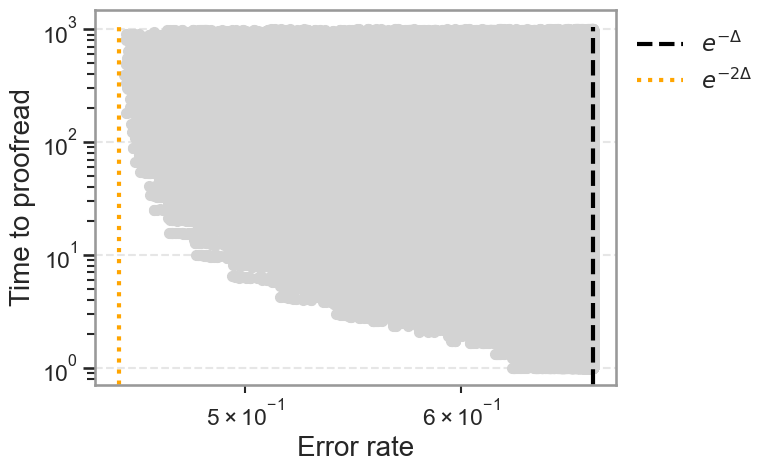

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(track_errorsp, track_fptsp, 'o', color='lightgray', markersize=7)

ylim = ax.get_ylim()
ax.plot([np.exp(-delta), np.exp(-delta)], ylim, '--', color = 'black', linewidth=3, label=r'$e^{-\Delta}$')
ax.plot([np.exp(-(N-int(N/2))*delta), np.exp(-(N-int(N/2))*delta)], ylim, ':', color = 'orange', linewidth=3, label=r'$e^{-%d\Delta}$'%(N-int(N/2)))
ax.set_xlabel('Error rate')
ax.set_ylabel(r'Time to proofread')

leg = plt.legend(bbox_to_anchor=(1, 1), frameon=False)

ax.set_xscale('log')
plt.yscale('log')
#plt.ylim([0, 1e4])
plt.tight_layout()
#plt.savefig('tradeoff_trajectories_N%d_tstall%d_T_%d.pdf' % (N, t_stall, T))
plt.show()

#### Loading the data saved previously from running the random sampling code above

In [7]:
import pickle
with open('kinetic-proofreading_data/scatter_trajs_N_3.pickle', 'rb') as handle:
    trajs = pickle.load(handle)

x = trajs[0]
y = trajs[1]

xx_3 = np.asarray(x)
yy_3 = np.asarray(y)
xy_3 = np.concatenate([xx_3, yy_3]).reshape(2, len(xx_3)).T

Saving the data

In [ ]:
# with open('pareto_trajs_N_3.pickle', 'wb') as handle:
#     pickle.dump(xy_3, handle, protocol=pickle.HIGHEST_PROTOCOL)

# trajs = [track_errorsp, track_fptsp]
# with open('scatter_trajs_N_3.pickle', 'wb') as handle:
#     pickle.dump(trajs, handle, protocol=pickle.HIGHEST_PROTOCOL)

Identifying the Pareto front

In [8]:
pareto_3 = identify_pareto(xy_3)

[ True  True  True ...  True  True  True]


  0%|          | 0/203418 [00:00<?, ?it/s]

In [9]:
idx_pareto_sorted_3 = np.argsort(xy_3[pareto_3,0])
pareto_sorted_3 = pareto_3[idx_pareto_sorted_3]

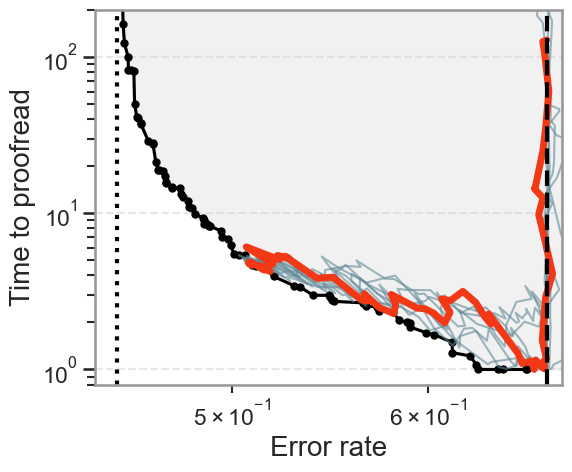

In [15]:
import pickle
# Loading saved trajectories of evolution for speed (N=3)
with open('kinetic-proofreading_data/N_3_trajs.pickle', 'rb') as handle:
     trajs = pickle.load(handle)

track_error_3 = trajs[2]
track_fpt_3 = trajs[4]

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.plot(xy_3[pareto_sorted_3,0], xy_3[pareto_sorted_3,1], '-o', color='black', markersize=5)

x_pareto = xy_3[pareto_sorted_3,0]
y_pareto = xy_3[pareto_sorted_3,1]
x_left = np.exp(-delta)
x_right = 6.8e-1  # Right edge of plot
# Create closed polygon: follow Pareto front, extend to right edge, go up, go left along top, go down at left, close
fill_x3 = np.concatenate([x_pareto, [x_right, x_right, x_left, x_left, x_pareto[0]]])
fill_y3 = np.concatenate([y_pareto, [y_pareto[-1], 1e3, 1e3, y_pareto[0], y_pareto[0]]])
plt.fill(fill_x3, fill_y3, color='lightgray', alpha=0.3)

trace = 3
for s in range(0,n_samples):
    if s != trace:
        ax.plot(track_error_3[s], track_fpt_3[s], '-', color=pal.wesanderson.Darjeeling2_5.mpl_colors[1], \
            linewidth=1.5, alpha=0.6, rasterized=False)  
s = trace
ax.plot(track_error_3[s], track_fpt_3[s], '-', color=pal.wesanderson.Zissou_5.mpl_colors[2], \
        linewidth=5, rasterized=False)
    
ylim = ax.get_ylim()
ax.plot([np.exp(-delta), np.exp(-delta)], ylim, '--', color = 'black', linewidth=3, label=r'$e^{-\Delta}$')
ax.plot([np.exp(-(N-int(N/2))*delta), np.exp(-(N-int(N/2))*delta)], ylim, ':', color = 'black', linewidth=3, \
        label=r'$e^{-%d\Delta}$'%(N-int(N/2)))
ax.set_xlabel('Error rate')
ax.set_ylabel(r'Time to proofread')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim([4.4e-1, 6.8e-1])
ax.set_ylim([0.8e0, 2e2])

plt.tight_layout()
#plt.savefig('tradeoff_trajectories_N%d_tstall%d_T_%d.pdf' % (N, t_stall, T))
plt.show()

## Evolutionary trajectory in a time to replicate vs error rate plot

|Number of nodes ($N$) | $T$ | $t_{\rm{stall}}$| $\delta$| size | dsize|
|-----------|-----|-----------------|---------|------|------|
|3| $10^{-2}$| $10^3$| 2.5| 5| 0.5|

In [80]:
N = 3 #  Size of the network
delta = 2.5   # The kinetics difference between R and W \
              #is fixed to be at most e^delta (-delta < eps < delta)
init = 0      # Definition of the initial state
size = 5
dsize = 0.5
maxsize = 5

eps_v, eps_b, p_0, end, V, B, mu, k_r, k_w, V_0, B_0, mu_0 = initialise_network(N, delta, init, size, dsize, maxsize)

Genome: [-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5
  2.   2.5  3.   3.5  4.   4.5] Length: 20
Error at initialisation: 0.08208499862389884 e^{-\Delta}: 0.0820849986238988
Sum over rows: [ 2.60208521e-18 -1.11022302e-16  0.00000000e+00]


In [82]:
q = 0
n_samples = 10
mcsteps = 100000
T = 1e-2 # Evolution temperature
  
t_st = [1000]

track_e, track_S = [ [] for i in range(2)]

for t_stall in t_st:
    print(t_stall)
    
    track_error_s, track_speed_s, track_fpt_s, track_fptw_s, track_mu_s, \
    track_ent_s, track_time_s, track_k_s = evolve(N, mcsteps, T, t_stall, q, delta, n_samples, \
                                                  size, dsize, maxsize)

1000


In [83]:
eps_v, eps_b, p_0, end, V, B, mu, k_r, k_w, V_0, B_0, mu_0 = initialise_network(N, delta, init, size, dsize, maxsize)

track_errorsp, track_fptsp = [ [] for i in range(2)]

n_scatter = int(1e6)
for i in range(n_scatter):
    
    k_r, k_w, V_r, B_r, mu_r = initialise_k_phi(V, B, mu, N, eps_v, eps_b)
        
    f = error(k_r, k_w, N, init, end).item()
    g = firstpt(copy.copy(k_r), p_0, N, end).item()
    if (f <= np.exp(-delta))*(g < 1e3):
        track_errorsp.append(f)
        track_fptsp.append(g)

Genome: [-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5
  2.   2.5  3.   3.5  4.   4.5] Length: 20
Error at initialisation: 0.08208499862389892 e^{-\Delta}: 0.0820849986238988
Sum over rows: [ 0.00000000e+00 -2.16840434e-19  0.00000000e+00]


In [84]:
trajs = [track_errorsp, track_fptsp]
x = trajs[0]
y = np.asarray(trajs[1])+t_stall*np.asarray(trajs[0])

xx = np.asarray(x)
yy = np.asarray(y)
xy = np.concatenate([xx, yy]).reshape(2, len(xx)).T

Identify the Pareto front

In [85]:
pareto = identify_U_shaped_pareto(xy)
idx_pareto_sorted = np.argsort(xy[pareto,0])
pareto_sorted = pareto[idx_pareto_sorted]

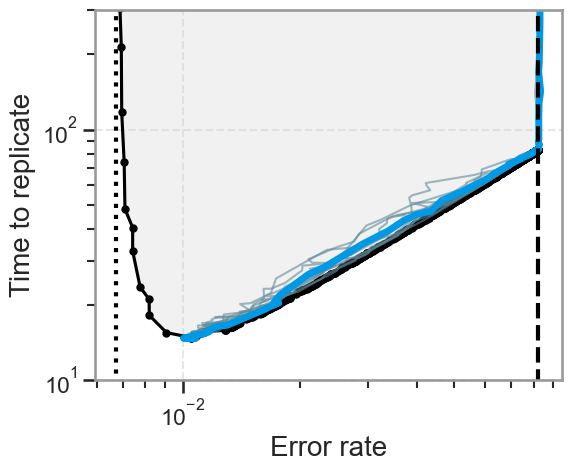

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

plt.plot(xy[pareto_sorted,0], xy[pareto_sorted,1], '-o', color='black', markersize=5)

x_pareto = xy[pareto_sorted,0]
y_pareto = xy[pareto_sorted,1]
x_left = np.exp(-delta)
# Create closed polygon: follow Pareto front, go up at right end, go left along top, go down at left, close
fill_x3 = np.concatenate([x_pareto, [x_pareto[-1], x_left, x_left, x_pareto[0]]])
fill_y3 = np.concatenate([y_pareto, [1e3, 1e3, y_pareto[0], y_pareto[0]]])
plt.fill(fill_x3, fill_y3, color='lightgray', alpha=0.3)

trace = 4
for s in range(0,n_samples):
    if s != trace:
        ax.plot(track_error_s[s], np.asarray(track_fpt_s[s])+t_stall*np.asarray(track_error_s[s]), '-', color=pal.wesanderson.Darjeeling2_5.mpl_colors[1], \
            linewidth=1.5, alpha=0.6, rasterized=False)  
s = trace
ax.plot(track_error_s[s],  np.asarray(track_fpt_s[s])+t_stall*np.asarray(track_error_s[s]), '-', color=pal.wesanderson.Zissou_5.mpl_colors[0], \
        linewidth=5, rasterized=False)
    
ylim = ax.get_ylim()
ax.plot([np.exp(-delta), np.exp(-delta)], ylim, '--', color = 'black', linewidth=3, label=r'$e^{-\Delta}$')
ax.plot([np.exp(-(N-int(N/2))*delta), np.exp(-(N-int(N/2))*delta)], ylim, ':', color = 'black', linewidth=3, \
        label=r'$e^{-%d\Delta}$'%(N-int(N/2)))
ax.set_xlabel('Error rate')
ax.set_ylabel(r'Time to replicate')

ax.set_xscale('log')
ax.set_yscale('log')

#ax.set_xlim([4.4e-1, 6.8e-1])
ax.set_ylim([1e1, 3e2])

plt.tight_layout()
# Save as publication-ready PDF with editable text for Illustrator
# plt.savefig('pareto_front_N%d_tstall%d_T_%d.pdf' % (N, t_stall, T), 
#             format='pdf', 
#             dpi=300, 
#             bbox_inches='tight',
#             pad_inches=0.1,
#             transparent=False)
plt.show()

In [ ]:
trajs = [track_errorsp, track_fptsp]
x = trajs[0]
y = np.asarray(trajs[1])+t_stall*np.asarray(trajs[0])

xx_3 = np.asarray(x)
yy_3 = np.asarray(y)
xy_3 = np.concatenate([xx_3, yy_3]).reshape(2, len(xx_3)).T

## Visualize networks with kinetic constants

Let's consider for example the kinetic matrix corresponding to the last time point in the evolution; [-1]. Similarly the initial one can be accessed with [0].

In [78]:
print("Kinetic matrix values: ", N, "x", N, "\n")
print(track_k_s[0][-1])

Kinetic matrix values:  7 x 7 

[[-9.91308802e-01  7.91052488e-04  1.23971540e-04  2.47590657e-04
   4.18215757e-01  2.50447299e-08  2.02689209e-09]
 [ 5.79042375e-05 -9.97337703e-01  2.03805547e-01  5.69971090e-05
   3.60992956e-02  2.19814046e-07  2.13160839e-09]
 [ 4.60867268e-06  5.92486183e-03 -1.20255821e+00  1.00000000e+00
   4.32610019e-04  8.31302621e-04  1.98951959e-09]
 [ 1.54947885e-05  6.61691489e-05  9.98071914e-01 -1.17758868e+00
   9.88009284e-01  8.47475234e-07  3.13478038e-08]
 [ 9.91229834e-01  9.90537005e-01  2.42164892e-04  1.60668492e-03
  -1.44283908e+00  1.17232715e-07  1.98951959e-09]
 [ 9.38170370e-07  6.50745592e-06  3.11426853e-04  1.10215880e-05
   2.66206397e-06 -2.25524116e-01  2.23060522e-03]
 [ 2.27559563e-08  1.21072155e-05  3.18516124e-06  1.75666384e-01
   7.94727816e-05  2.24691604e-01 -2.23064471e-03]]


7 42


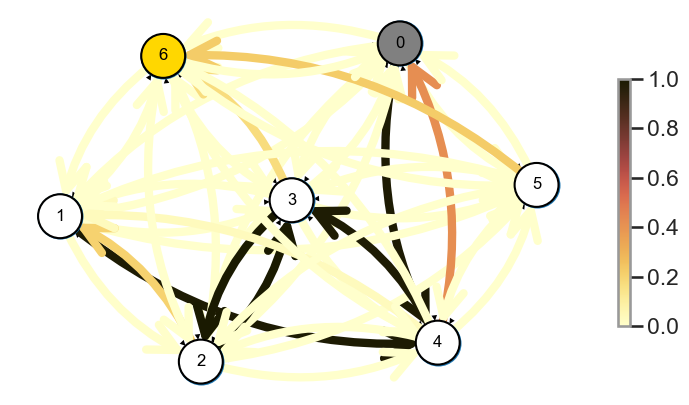

In [79]:
%autoreload 2
from plot import plot_single_network
plot_single_network(track_k_s[0][-1], N, t_stall, T)

#### Hopfield network

Defining the discrimination factor for an Hopfield network

In [23]:
delta_h = 4
np.exp(-2*delta_h)

np.float64(0.00033546262790251185)

In [24]:
N = 3
init = 0
end = N - 1
k_rH = np.zeros([1, N, N])
k_rH[0][0,1] = 1
k_rH[0][1,0] = 1
k_rH[0][2,0] = 1e-8
k_rH[0][0,2] = 1e-1
k_rH[0][1,2] = 1e-8
k_rH[0][2,1] = 1e-3
k_rH[0] = normalise_outflow(k_rH[0], N)

In [25]:
k_wH = copy.deepcopy(k_rH)
k_wH1 = np.zeros([1,N,N])

for i in range(N):
    for j in range(N):
        if i < int(N/2) and j >= int(N/2):
            k_wH[0][i,j] = k_wH[0][i,j]*np.exp(delta_h)

k_wH[0] = normalise_outflow(k_wH[0], N)
k_wH1[0] = copy.copy(k_wH[0])/max_k(copy.copy(k_rH[0]))

In [27]:
print(np.exp(-2*delta_h), error(k_rH[0], k_wH1[0], N, init, end))

0.00033546262790251185 0.00033597194970116885


3 6


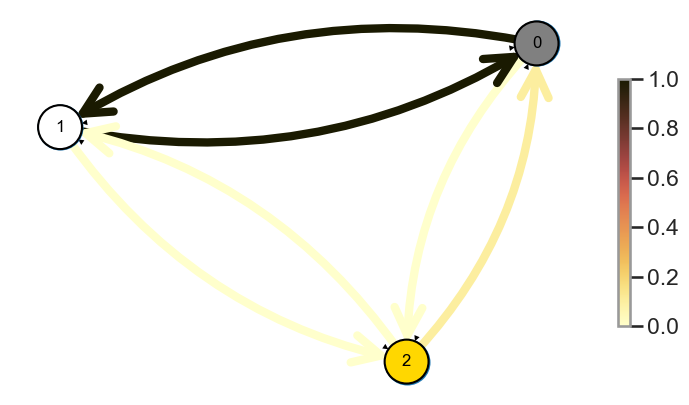

In [95]:
# %load_ext autoreload
%autoreload 2
t_stall = 0
T = 0

# If flag_mean = 1 plot full network, if = 0 plot sample=sample
flag_mean = 0
plot_single_network(k_rH[0].tolist(), N, t_stall, T)